# User Segmentation & Clustering

## Цель
Найти 4-7 осмысленных кластеров пользователей на основе их поведения и характеристик.

## Подход
1. **Feature Preparation** - выбор фичей для кластеризации (RFM + behavioral)
2. **Dimensionality Reduction** - UMAP/t-SNE для визуализации
3. **Clustering** - KMeans для поиска кластеров
4. **Cluster Analysis** - анализ профилей и conversion rate
5. **Visualizations** - 2D/3D scatter plots, radar charts, heatmaps

## Ожидаемые сегменты
- **Regular Buyers** - частые заказы, высокий lifetime
- **Discount Hunters** - покупают только со скидками
- **Impulsive Buyers** - редкие, но крупные заказы
- **Browsers** - много кликов, мало покупок
- **New Users** - недавние регистрации
- **Churned** - давно не покупали

## 1. Imports and Configuration

In [ ]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [20]:
# Configuration
DATA_DIR = '../results'
MODELS_DIR = '../models'
FIGURES_DIR = '../results/figures'

# Create directories
os.makedirs(FIGURES_DIR, exist_ok=True)

# Random seed
RANDOM_STATE = 42

print(f"Data directory: {DATA_DIR}")
print(f"Models directory: {MODELS_DIR}")
print(f"Figures directory: {FIGURES_DIR}")
print(f"Random state: {RANDOM_STATE}")

Data directory: ../results
Models directory: ../models
Figures directory: ../results/figures
Random state: 42


## 2. Load Data and Features

In [21]:
# Load training features (with target)
print("Loading features...")
df_train = pd.read_parquet(os.path.join(DATA_DIR, 'features_train_v2.parquet'))

print(f"\nData shape: {df_train.shape}")
print(f"\nTarget distribution:")
print(df_train['target'].value_counts())
print(f"\nPositive rate: {df_train['target'].mean():.2%}")

df_train.head()

Loading features...

Data shape: (1835147, 337)

Target distribution:
target
0    1200425
1     634722
Name: count, dtype: int64

Positive rate: 34.59%


user_id  target  num_products_click  num_unique_products_click  \
0       16       0                 1.0                        1.0   
1       34       0                -1.0                       -1.0   
2       36       1                 9.0                        9.0   
3       53       0                -1.0                       -1.0   
4       54       0                 1.0                        1.0   

   sum_discount_price_click  max_discount_price_click  days_since_last_click  \
0                     335.0                     335.0                  118.0   
1                      -1.0                      -1.0                   -1.0   
2                   20407.0                   17257.0                   49.0   
3                      -1.0                      -1.0                   -1.0   
4                     110.0                     110.0                    4.0   

   days_since_first_click  num_products_favorite  \
0                   118.0                   -1.0   
1                    -1.0                   -1.0   
2                    73.0                   -1.0   
3                    -1.0                   -1.0   
4                     4.0                   -1.0   

   num_unique_products_favorite  ...  timestamp_std_search_0_4  \
0                          -1.0  ...                       0.0   
1                          -1.0  ...                       0.0   
2                          -1.0  ...                       0.0   
3                          -1.0  ...                       0.0   
4                          -1.0  ...                       0.0   

   timestamp_std_search_1_4  timestamp_std_search_2_4  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   timestamp_std_search_3_4  timestamp_std_search_4_4  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   unique_widget_search_0_4  unique_widget_search_1_4  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   unique_widget_search_2_4  unique_widget_search_3_4  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       1.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   unique_widget_search_4_4  
0                  0.000000  
1                  0.000000  
2                  0.000000  
3                  0.000000  
4                  0.021505  

[5 rows x 337 columns]

## 3. Feature Selection for Clustering

Выберем наиболее важные фичи для кластеризации:
- **RFM features**: Recency, Frequency, Monetary
- **Behavioral features**: активность, паттерны, конверсии

In [22]:
# Ключевые фичи для кластеризации
clustering_features = [
    # Order-related (RFM)
    'num_products_order',
    'days_since_last_order',
    'sum_discount_price_order',
    'num_unique_days_order',
    
    # Engagement features
    'num_products_click',
    'num_products_to_cart',
    'num_search',
    
    # Conversion features
    'click_to_order_conversion',
    'to_cart_to_order_conversion',
    
    # Behavioral patterns
    'avg_hour_order',
    'lifetime_order',
]

# Проверим доступность фичей
available_features = [f for f in clustering_features if f in df_train.columns]
missing_features = [f for f in clustering_features if f not in df_train.columns]

print(f"Available features: {len(available_features)}/{len(clustering_features)}")
print(f"\nAvailable: {available_features}")

if missing_features:
    print(f"\n⚠️ Missing features: {missing_features}")
    print("\nSearching for similar features...")
    for missing in missing_features:
        similar = [col for col in df_train.columns if missing.split('_')[0] in col.lower()]
        if similar:
            print(f"  {missing} -> Similar: {similar[:3]}")

# Используем только доступные фичи
clustering_features = available_features
print(f"\nFinal clustering features: {len(clustering_features)}")

Available features: 11/11

Available: ['num_products_order', 'days_since_last_order', 'sum_discount_price_order', 'num_unique_days_order', 'num_products_click', 'num_products_to_cart', 'num_search', 'click_to_order_conversion', 'to_cart_to_order_conversion', 'avg_hour_order', 'lifetime_order']

Final clustering features: 11


In [23]:
# Подготовка данных для кластеризации
X_cluster = df_train[clustering_features].copy()

# Обработка пропусков (заменить -1 на 0 или медиану)
print("Handling missing values...")
print(f"\nMissing values before:")
print((X_cluster == -1).sum())

# Заменить -1 на 0 для большинства фичей
X_cluster = X_cluster.replace(-1, 0)

# Проверка на inf и nan
X_cluster = X_cluster.replace([np.inf, -np.inf], np.nan)
X_cluster = X_cluster.fillna(0)

print(f"\nShape after preprocessing: {X_cluster.shape}")
print(f"\nBasic statistics:")
print(X_cluster.describe())

Handling missing values...

Missing values before:
num_products_order             1325503
days_since_last_order          1325503
sum_discount_price_order       1325503
num_unique_days_order          1325503
num_products_click              774477
num_products_to_cart            912951
num_search                      806656
click_to_order_conversion      1351647
to_cart_to_order_conversion    1346532
avg_hour_order                 1325503
lifetime_order                 1325503
dtype: int64

Shape after preprocessing: (1835147, 11)

Basic statistics:
       num_products_order  days_since_last_order  sum_discount_price_order  \
count        1.835147e+06           1.835147e+06              1.835147e+06   
mean         9.693610e+00           6.787295e+00              2.275501e+03   
std          3.891108e+01           1.812614e+01              8.645726e+03   
min          0.000000e+00           0.000000e+00              0.000000e+00   
25%          0.000000e+00           0.000000e+00        

In [24]:
# Нормализация фичей (важно для кластеризации!)
print("Scaling features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

print(f"Scaled data shape: {X_scaled.shape}")
print(f"Mean: {X_scaled.mean(axis=0).round(2)}")
print(f"Std: {X_scaled.std(axis=0).round(2)}")

Scaling features...
Scaled data shape: (1835147, 11)
Mean: [-0. -0.  0.  0. -0.  0.  0.  0.  0.  0. -0.]
Std: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## 4. Dimensionality Reduction

Используем PCA для визуализации в 2D и 3D

In [25]:
# PCA 2D
print("Running PCA 2D...")
pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca_2d = pca_2d.fit_transform(X_scaled)

print(f"PCA 2D shape: {X_pca_2d.shape}")
print(f"PCA 2D range: [{X_pca_2d.min():.2f}, {X_pca_2d.max():.2f}]")

Running PCA 2D...
PCA 2D shape: (1835147, 2)
PCA 2D range: [-26.91, 2252.01]


In [26]:
# PCA 3D
print("Running PCA 3D...")
pca_3d = PCA(n_components=3, random_state=RANDOM_STATE)
X_pca_3d = pca_3d.fit_transform(X_scaled)

print(f"PCA 3D shape: {X_pca_3d.shape}")
print(f"PCA 3D range: [{X_pca_3d.min():.2f}, {X_pca_3d.max():.2f}]")

Running PCA 3D...
PCA 3D shape: (1835147, 3)
PCA 3D range: [-49.39, 2252.01]


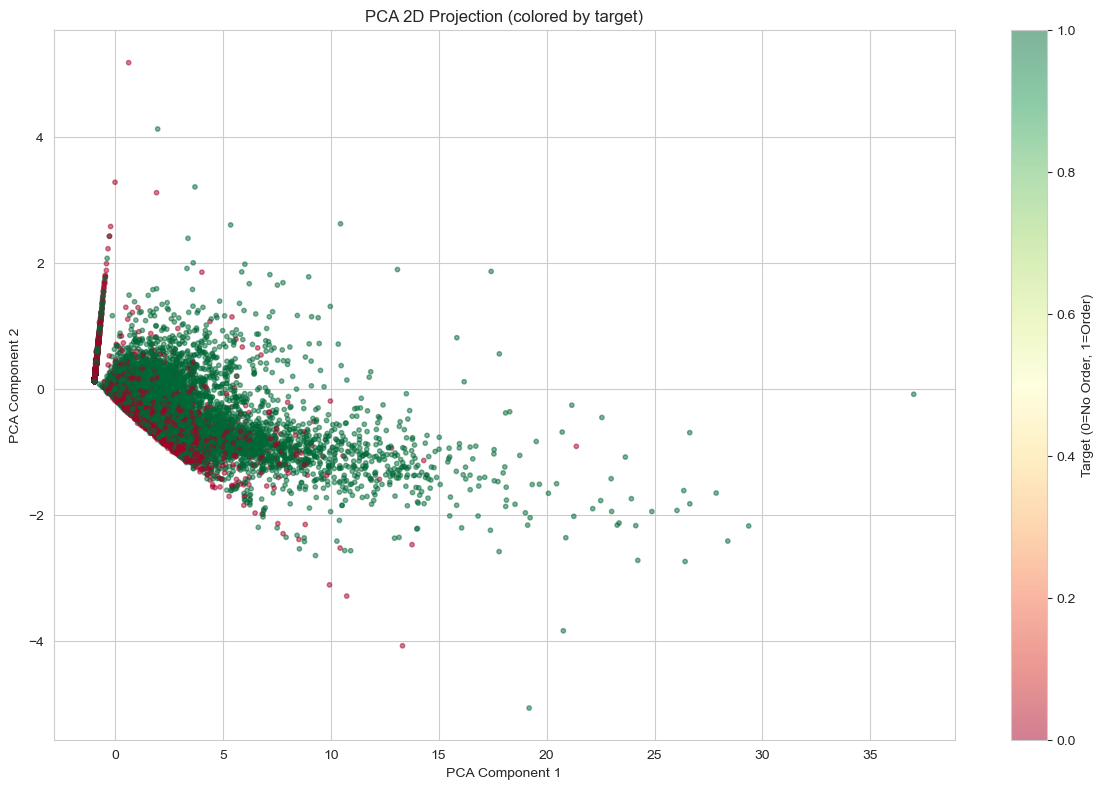

Plot saved to ../results/figures/pca_2d_target.png


In [27]:
# Визуализация PCA 2D с target
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Sample для быстрой визуализации
sample_size = 50000
sample_idx = np.random.choice(len(X_pca_2d), size=min(sample_size, len(X_pca_2d)), replace=False)

scatter = ax.scatter(
    X_pca_2d[sample_idx, 0],
    X_pca_2d[sample_idx, 1],
    c=df_train['target'].iloc[sample_idx],
    cmap='RdYlGn',
    alpha=0.5,
    s=10
)

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_title('PCA 2D Projection (colored by target)')
plt.colorbar(scatter, ax=ax, label='Target (0=No Order, 1=Order)')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'pca_2d_target.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"Plot saved to {FIGURES_DIR}/pca_2d_target.png")

## 5. Clustering with KMeans

Найдем оптимальное количество кластеров (4-7)

STEP 1: FILTER ACTIVE vs INACTIVE USERS

Total users: 1,835,147
Active users: 1,226,313 (66.8%)
Inactive users: 608,834 (33.2%)

Active users shape: (1226313, 11)
Inactive users shape: (608834, 11)

STEP 2: CLUSTERING ACTIVE USERS (k=3,4,5)

Data size: 1,226,313 active users
Sample size for silhouette: 50,000

🔍 Testing k=3...
  ⏱️  Clustering time: 0.20s
  ✅ Inertia: 12,264,225.30
  ✅ Silhouette (sample): 0.6068
  ✅ Davies-Bouldin: 1.0565
  ⏱️  Total time: 1.06s
  📊 Cluster sizes:
     Cluster 0: 399,411 (32.6%)
     Cluster 1: 84,741 (6.9%)
     Cluster 2: 742,161 (60.5%)

🔍 Testing k=4...
  ⏱️  Clustering time: 0.35s
  ✅ Inertia: 10,967,813.56
  ✅ Silhouette (sample): 0.6211
  ✅ Davies-Bouldin: 1.1345
  ⏱️  Total time: 1.25s
  📊 Cluster sizes:
     Cluster 0: 737,979 (60.2%)
     Cluster 1: 341,999 (27.9%)
     Cluster 2: 16,927 (1.4%)
     Cluster 3: 129,408 (10.6%)

🔍 Testing k=5...
  ⏱️  Clustering time: 0.23s
  ✅ Inertia: 10,220,851.05
  ✅ Silhouette (sample): 0.6418
  ✅ Davies-

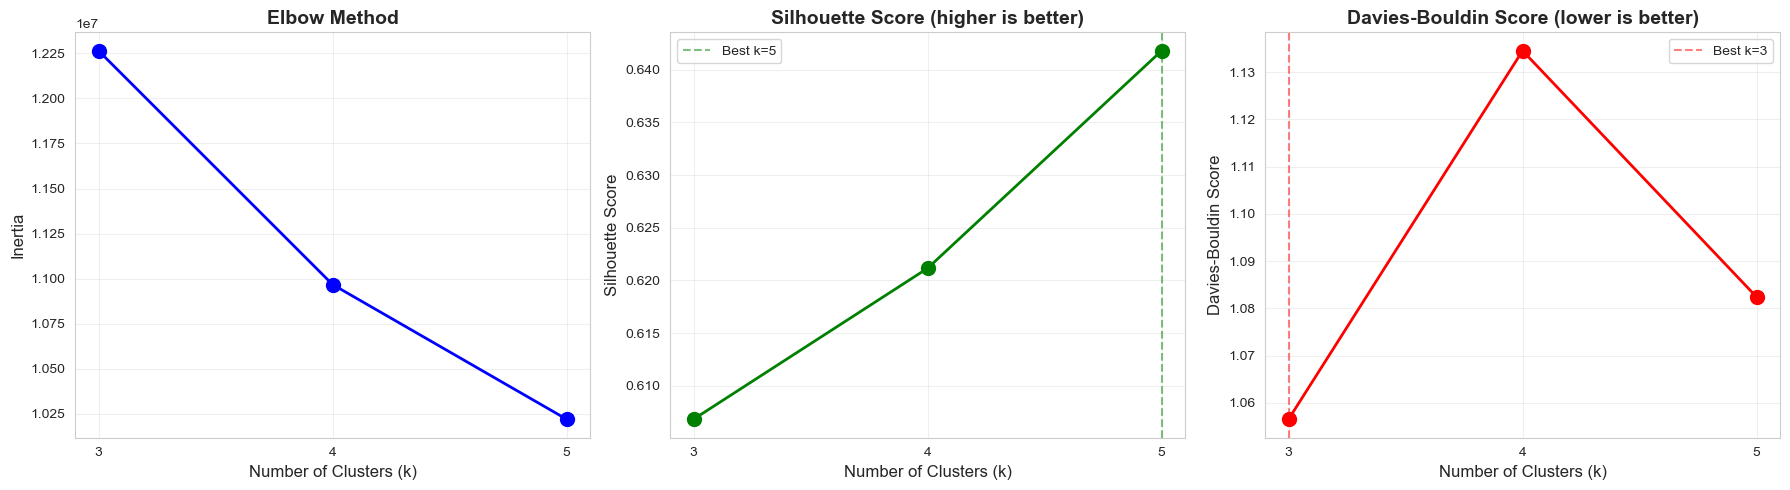


🎯 Optimal number of clusters: 5
   Silhouette Score: 0.6418
   Davies-Bouldin Score: 1.0824
   Saved figure: ../results/figures/clustering_metrics_active.png


In [59]:
from sklearn.cluster import MiniBatchKMeans
import time

print("=" * 80)
print("STEP 1: FILTER ACTIVE vs INACTIVE USERS")
print("=" * 80)

# Создать маску активных пользователей (хотя бы одно действие)
active_mask = (
    (df_train['num_products_click'] > 0) |
    (df_train['num_products_to_cart'] > 0) |
    (df_train['num_search'] > 0) |
    (df_train['num_products_order'] > 0)
)

print(f"\nTotal users: {len(df_train):,}")
print(f"Active users: {active_mask.sum():,} ({active_mask.mean():.1%})")
print(f"Inactive users: {(~active_mask).sum():,} ({(~active_mask).mean():.1%})")

# Разделить на активных и неактивных
X_scaled_active = X_scaled[active_mask]
X_scaled_inactive = X_scaled[~active_mask]

print(f"\nActive users shape: {X_scaled_active.shape}")
print(f"Inactive users shape: {X_scaled_inactive.shape}")

# =====================================================================
# STEP 2: CLUSTERING ONLY ACTIVE USERS
# =====================================================================

print("\n" + "=" * 80)
print("STEP 2: CLUSTERING ACTIVE USERS (k=3,4,5)")
print("=" * 80)

# Попробуем k=3,4,5 (меньше вариантов = быстрее)
k_range = range(3, 6)
METRIC_SAMPLE_SIZE = 50000  # Sample для silhouette

inertias = []
silhouette_scores = []
davies_bouldin_scores = []
all_labels = {}  # Сохраним все labels для последующего анализа

# Sample для метрик (один раз)
np.random.seed(42)
metric_sample_idx = np.random.choice(
    len(X_scaled_active),
    size=min(METRIC_SAMPLE_SIZE, len(X_scaled_active)),
    replace=False
)
X_sample = X_scaled_active[metric_sample_idx]

print(f"\nData size: {len(X_scaled_active):,} active users")
print(f"Sample size for silhouette: {len(X_sample):,}\n")

for k in k_range:
    print(f"{'='*70}")
    print(f"🔍 Testing k={k}...")
    print(f"{'='*70}")

    start_time = time.time()

    # MiniBatchKMeans - быстрая версия KMeans
    kmeans = MiniBatchKMeans(
        n_clusters=k,
        random_state=42,
        batch_size=10000,
        max_iter=100,
        n_init=10,
        verbose=0
    )

    # Fit на активных пользователях
    labels = kmeans.fit_predict(X_scaled_active)
    all_labels[k] = labels  # Сохраним

    fit_time = time.time() - start_time

    # 1. Inertia
    inertia = kmeans.inertia_
    inertias.append(inertia)

    # 2. Davies-Bouldin (быстро)
    db_score = davies_bouldin_score(X_scaled_active, labels)
    davies_bouldin_scores.append(db_score)

    # 3. Silhouette (на sample)
    sample_labels = labels[metric_sample_idx]
    sil_score = silhouette_score(
        X_sample,
        sample_labels,
        sample_size=min(10000, len(X_sample))
    )
    silhouette_scores.append(sil_score)

    total_time = time.time() - start_time

    print(f"  ⏱️  Clustering time: {fit_time:.2f}s")
    print(f"  ✅ Inertia: {inertia:,.2f}")
    print(f"  ✅ Silhouette (sample): {sil_score:.4f}")
    print(f"  ✅ Davies-Bouldin: {db_score:.4f}")
    print(f"  ⏱️  Total time: {total_time:.2f}s")

    # Показать размеры кластеров
    unique, counts = np.unique(labels, return_counts=True)
    print(f"  📊 Cluster sizes:")
    for label, count in zip(unique, counts):
        pct = count / len(labels) * 100
        print(f"     Cluster {label}: {count:,} ({pct:.1f}%)")
    print()

# =====================================================================
# STEP 3: VISUALIZE METRICS & SELECT OPTIMAL k
# =====================================================================

print("=" * 80)
print("STEP 3: METRICS COMPARISON")
print("=" * 80)

# Сводная таблица результатов
print(f"\n{'k':<5} {'Inertia':<15} {'Silhouette':<12} {'Davies-Bouldin':<15}")
print("-" * 50)
for i, k in enumerate(k_range):
    print(f"{k:<5} {inertias[i]:<15,.2f} {silhouette_scores[i]:<12.4f} {davies_bouldin_scores[i]:<15.4f}")
print()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Elbow (Inertia)
axes[0].plot(k_range, inertias, "bo-", linewidth=2, markersize=10)
axes[0].set_xlabel("Number of Clusters (k)", fontsize=12)
axes[0].set_ylabel("Inertia", fontsize=12)
axes[0].set_title("Elbow Method", fontsize=14, fontweight="bold")
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(list(k_range))

# Silhouette (higher is better)
axes[1].plot(k_range, silhouette_scores, "go-", linewidth=2, markersize=10)
axes[1].set_xlabel("Number of Clusters (k)", fontsize=12)
axes[1].set_ylabel("Silhouette Score", fontsize=12)
axes[1].set_title("Silhouette Score (higher is better)", fontsize=14, fontweight="bold")
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(list(k_range))

best_sil_idx = int(np.argmax(silhouette_scores))
best_sil_k = list(k_range)[best_sil_idx]
axes[1].axvline(x=best_sil_k, color="green", linestyle="--", alpha=0.5, label=f"Best k={best_sil_k}")
axes[1].legend()

# Davies-Bouldin (lower is better)
axes[2].plot(k_range, davies_bouldin_scores, "ro-", linewidth=2, markersize=10)
axes[2].set_xlabel("Number of Clusters (k)", fontsize=12)
axes[2].set_ylabel("Davies-Bouldin Score", fontsize=12)
axes[2].set_title("Davies-Bouldin Score (lower is better)", fontsize=14, fontweight="bold")
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(list(k_range))

best_db_idx = int(np.argmin(davies_bouldin_scores))
best_db_k = list(k_range)[best_db_idx]
axes[2].axvline(x=best_db_k, color="red", linestyle="--", alpha=0.5, label=f"Best k={best_db_k}")
axes[2].legend()

plt.tight_layout()

os.makedirs(FIGURES_DIR, exist_ok=True)
out_path = os.path.join(FIGURES_DIR, "clustering_metrics_active.png")
plt.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()

# Select optimal k (by silhouette)
optimal_k = best_sil_k
opt_idx = list(k_range).index(optimal_k)

print(f"\n🎯 Optimal number of clusters: {optimal_k}")
print(f"   Silhouette Score: {silhouette_scores[opt_idx]:.4f}")
print(f"   Davies-Bouldin Score: {davies_bouldin_scores[opt_idx]:.4f}")
print(f"   Saved figure: {out_path}")




STEP 4: FINAL CLUSTERING (k=5)

Running final MiniBatchKMeans with k=5...
✅ Done in 0.35s

STEP 5: ASSIGNING CLUSTERS TO ALL USERS

Cluster assignment complete!

Final cluster distribution:
  Cluster -1 (Inactive):   608,834 ( 33.2%)
  Cluster  0:             728,631 ( 39.7%)
  Cluster  1:              85,756 (  4.7%)
  Cluster  2:              21,806 (  1.2%)
  Cluster  3:             277,784 ( 15.1%)
  Cluster  4:             112,336 (  6.1%)


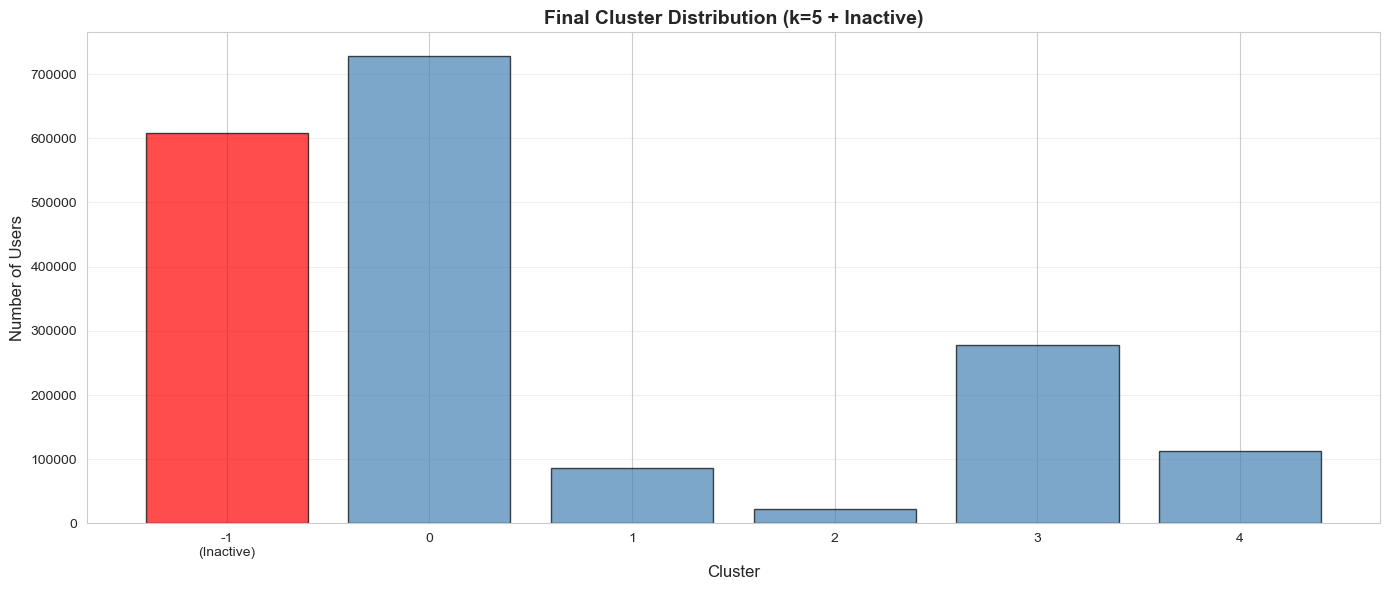


✅ CLUSTERING COMPLETE!

✅ All users successfully assigned to clusters
   Saved figure: ../results/figures/final_cluster_distribution.png


In [60]:
# =====================================================================
# STEP 4: FINAL CLUSTERING WITH OPTIMAL k
# =====================================================================
print("\n" + "=" * 80)

print(f"STEP 4: FINAL CLUSTERING (k={optimal_k})")
print("=" * 80)

print(f"\nRunning final MiniBatchKMeans with k={optimal_k}...")

start_time = time.time()

kmeans_final = MiniBatchKMeans(
    n_clusters=optimal_k,
    random_state=RANDOM_STATE,
    batch_size=10_000,
    max_iter=300,
    n_init=20,
    verbose=0
)

# Cluster only active users
labels_active = kmeans_final.fit_predict(X_scaled_active)

elapsed = time.time() - start_time
print(f"✅ Done in {elapsed:.2f}s")


# =====================================================================
# STEP 5: ASSIGN CLUSTERS (active + inactive)
# =====================================================================

print("\n" + "=" * 80)
print("STEP 5: ASSIGNING CLUSTERS TO ALL USERS")
print("=" * 80)

# Create cluster column
df_train["cluster"] = -999  # placeholder

# Active users: clusters 0..k-1
df_train.loc[active_mask, "cluster"] = labels_active

# Inactive users: cluster -1
df_train.loc[~active_mask, "cluster"] = -1

print("\nCluster assignment complete!")
print("\nFinal cluster distribution:")

cluster_counts = df_train["cluster"].value_counts().sort_index()

for cluster_id, count in cluster_counts.items():
    pct = count / len(df_train) * 100
    if cluster_id == -1:
        print(f"  Cluster {cluster_id} (Inactive):  {count:8,} ({pct:5.1f}%)")
    else:
        print(f"  Cluster {cluster_id:2d}:            {count:8,} ({pct:5.1f}%)")

# Plot final distribution
plt.figure(figsize=(14, 6))

cluster_idx = cluster_counts.index.tolist()
bar_colors = ["red" if c == -1 else "steelblue" for c in cluster_idx]

plt.bar(
    range(len(cluster_counts)),
    cluster_counts.values,
    color=bar_colors,
    alpha=0.7,
    edgecolor="black"
)

plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Number of Users", fontsize=12)
plt.title(f"Final Cluster Distribution (k={optimal_k} + Inactive)", fontsize=14, fontweight="bold")

x_labels = [f"{c}\n(Inactive)" if c == -1 else str(c) for c in cluster_idx]
plt.xticks(range(len(cluster_counts)), x_labels)
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
os.makedirs(FIGURES_DIR, exist_ok=True)
dist_path = os.path.join(FIGURES_DIR, "final_cluster_distribution.png")
plt.savefig(dist_path, dpi=150, bbox_inches="tight")
plt.show()

print("\n" + "=" * 80)
print("✅ CLUSTERING COMPLETE!")
print("=" * 80)

# Sanity check: no unassigned users
assert (df_train["cluster"] != -999).all(), "❌ Some users not assigned to clusters!"
print("\n✅ All users successfully assigned to clusters")
print(f"   Saved figure: {dist_path}")


## 6. Cluster Analysis

Анализ профилей каждого кластера

In [61]:
# Профиль каждого кластера
print("Analyzing cluster profiles...\n")

# Выбрать ключевые фичи для анализа
analysis_features = clustering_features + ['target']

# Группировка по кластерам
cluster_profiles = df_train.groupby('cluster')[analysis_features].agg(['mean', 'median', 'std'])

print("Cluster Profiles (mean values):")
print(cluster_profiles.xs('mean', level=1, axis=1).round(2))

Analyzing cluster profiles...

Cluster Profiles (mean values):
         num_products_order  days_since_last_order  sum_discount_price_order  \
cluster                                                                        
-1                    -1.00                  -1.00                     -1.00   
 0                    -0.91                  -0.78                     24.22   
 1                     8.93                  76.00                   2563.37   
 2                   277.69                   5.98                  59466.11   
 3                    15.11                  14.79                   3969.07   
 4                    59.79                  13.79                  13694.90   

         num_unique_days_order  num_products_click  num_products_to_cart  \
cluster                                                                    
-1                       -1.00               -1.00                 -1.00   
 0                       -0.97               11.99                 1


CONVERSION RATE BY CLUSTER
         Conversion Rate  Orders  Total Users
cluster                                      
-1                 19.08  116163       608834
 0                 25.50  185765       728631
 1                 40.52   34747        85756
 2                 95.99   20932        21806
 3                 68.17  189353       277784
 4                 78.12   87762       112336


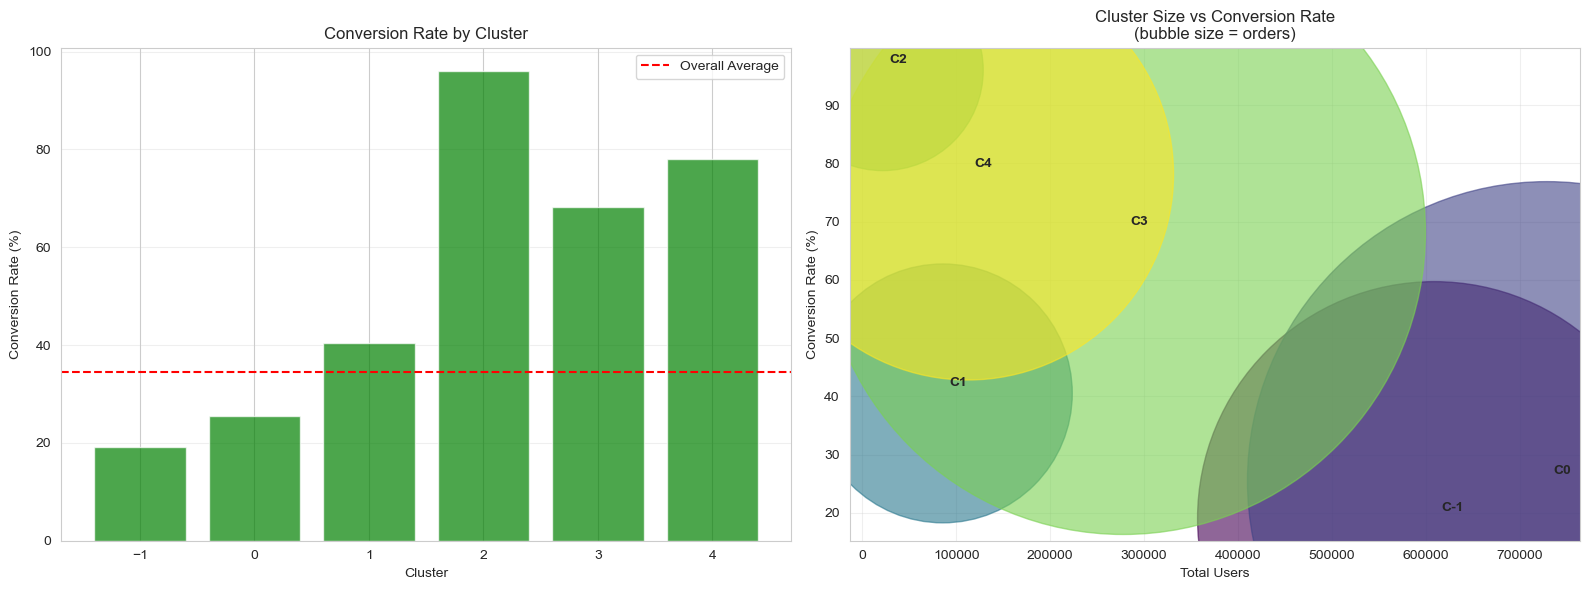

In [63]:
# Conversion rate по кластерам
conversion_by_cluster = df_train.groupby('cluster')['target'].agg(['mean', 'sum', 'count'])
conversion_by_cluster.columns = ['Conversion Rate', 'Orders', 'Total Users']
conversion_by_cluster['Conversion Rate'] = conversion_by_cluster['Conversion Rate'] * 100

print("\n" + "="*60)
print("CONVERSION RATE BY CLUSTER")
print("="*60)
print(conversion_by_cluster.round(2))

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Conversion rate
axes[0].bar(conversion_by_cluster.index, conversion_by_cluster['Conversion Rate'], color='green', alpha=0.7)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Conversion Rate (%)')
axes[0].set_title('Conversion Rate by Cluster')
axes[0].axhline(y=df_train['target'].mean() * 100, color='red', linestyle='--', label='Overall Average')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Cluster size vs conversion
axes[1].scatter(
    conversion_by_cluster['Total Users'],
    conversion_by_cluster['Conversion Rate'],
    s=conversion_by_cluster['Orders'],
    alpha=0.6,
    c=range(len(conversion_by_cluster)),
    cmap='viridis'
)
axes[1].set_xlabel('Total Users')
axes[1].set_ylabel('Conversion Rate (%)')
axes[1].set_title('Cluster Size vs Conversion Rate\n(bubble size = orders)')
axes[1].grid(True, alpha=0.3)

# Добавить аннотации
for idx, row in conversion_by_cluster.iterrows():
    axes[1].annotate(
        f'C{idx}',
        xy=(row['Total Users'], row['Conversion Rate']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=10,
        fontweight='bold'
    )

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'conversion_by_cluster.png'), dpi=150, bbox_inches='tight')
plt.show()

In [64]:
# =====================================================================
# IMPROVED CLUSTER NAMING (учитывает все кластеры включая -1)
# =====================================================================
cluster_names = {}
cluster_descriptions = {}

# Получить все уникальные кластеры (включая -1 для Inactive)
all_cluster_ids = sorted(df_train['cluster'].unique())

for cluster_id in all_cluster_ids:
    cluster_data = df_train[df_train['cluster'] == cluster_id]
    
    avg_orders = cluster_data['num_products_order'].mean()
    avg_recency = cluster_data['days_since_last_order'].mean()
    conversion = cluster_data['target'].mean()
    cluster_size = len(cluster_data)
    
    # Логика именования на основе РЕАЛЬНЫХ данных
    if cluster_id == -1:
        # Inactive users
        name = "Inactive Users"
        desc = "Very low engagement, minimal or no activity"
    
    elif conversion >= 0.90:
        # Super high conversion (96%)
        name = "VIP Buyers"
        desc = "Premium customers, almost guaranteed conversion"
    
    elif conversion >= 0.75:
        # High conversion (78%)
        name = "Loyal Buyers"
        desc = "Highly engaged, frequent purchasers"
    
    elif conversion >= 0.60:
        # Good conversion (68%)
        name = "Regular Buyers"
        desc = "Consistent customers with good conversion rate"
    
    elif conversion >= 0.35:
        # Medium conversion (40%)
        name = "Occasional Buyers"
        desc = "Moderate engagement, buys sometimes"
    
    else:
        # Low conversion (19-25%)
        if avg_orders > 0:
            name = "Window Shoppers"
            desc = "High browsing, low conversion"
        else:
            name = "Browsers"
            desc = "Mostly browsing, rarely buys"
    
    cluster_names[cluster_id] = name
    cluster_descriptions[cluster_id] = desc

# Вывод улучшенного неймінга
print("\n" + "="*70)
print("IMPROVED CLUSTER NAMING")
print("="*70)

for cluster_id in all_cluster_ids:
    cluster_data = df_train[df_train['cluster'] == cluster_id]
    print(f"\nCluster {cluster_id}: {cluster_names[cluster_id]}")
    print(f"  Description: {cluster_descriptions[cluster_id]}")
    print(f"  Size: {len(cluster_data):,}")
    print(f"  Conversion: {cluster_data['target'].mean():.2%}")


IMPROVED CLUSTER NAMING

Cluster -1: Inactive Users
  Description: Very low engagement, minimal or no activity
  Size: 608,834
  Conversion: 19.08%

Cluster 0: Browsers
  Description: Mostly browsing, rarely buys
  Size: 728,631
  Conversion: 25.50%

Cluster 1: Occasional Buyers
  Description: Moderate engagement, buys sometimes
  Size: 85,756
  Conversion: 40.52%

Cluster 2: VIP Buyers
  Description: Premium customers, almost guaranteed conversion
  Size: 21,806
  Conversion: 95.99%

Cluster 3: Regular Buyers
  Description: Consistent customers with good conversion rate
  Size: 277,784
  Conversion: 68.17%

Cluster 4: Loyal Buyers
  Description: Highly engaged, frequent purchasers
  Size: 112,336
  Conversion: 78.12%


## 7. Visualizations

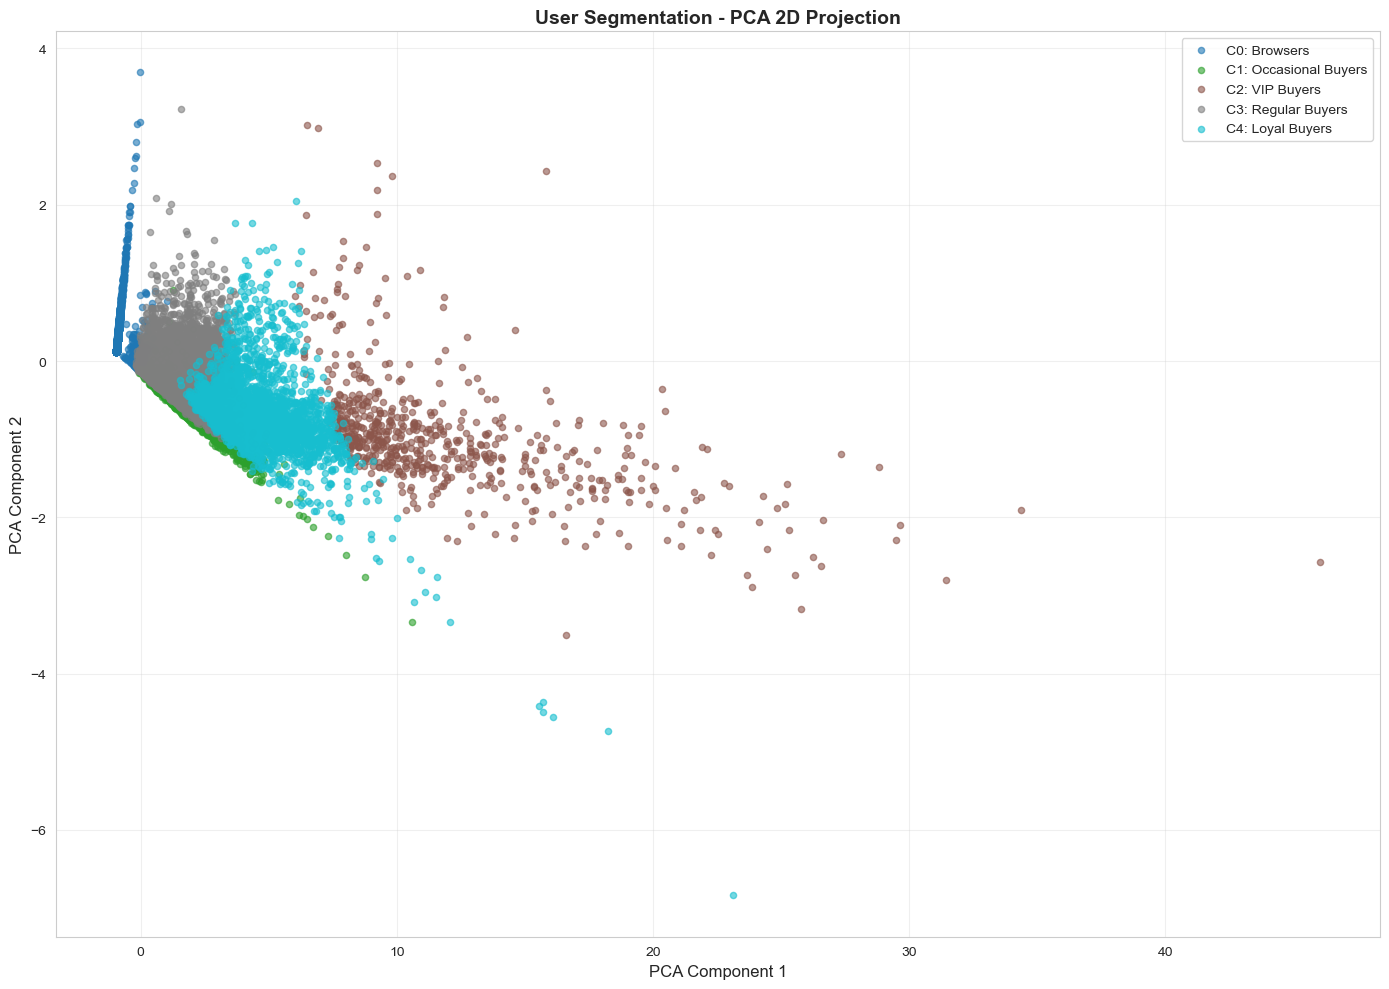

Plot saved to ../results/figures/pca_2d_clusters.png


In [65]:
# PCA 2D с кластерами
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Sample для визуализации
sample_size = 50000
sample_idx = np.random.choice(len(X_pca_2d), size=min(sample_size, len(X_pca_2d)), replace=False)

# Plot каждый кластер отдельным цветом
colors = plt.cm.tab10(np.linspace(0, 1, optimal_k))

for cluster_id in range(optimal_k):
    cluster_mask = df_train['cluster'].iloc[sample_idx] == cluster_id
    ax.scatter(
        X_pca_2d[sample_idx][cluster_mask, 0],
        X_pca_2d[sample_idx][cluster_mask, 1],
        c=[colors[cluster_id]],
        label=f"C{cluster_id}: {cluster_names[cluster_id]}",
        alpha=0.6,
        s=20
    )

ax.set_xlabel('PCA Component 1', fontsize=12)
ax.set_ylabel('PCA Component 2', fontsize=12)
ax.set_title('User Segmentation - PCA 2D Projection', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'pca_2d_clusters.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"Plot saved to {FIGURES_DIR}/pca_2d_clusters.png")

In [66]:
# Interactive 3D PCA with Plotly
sample_size_3d = 30000
sample_idx_3d = np.random.choice(len(X_pca_3d), size=min(sample_size_3d, len(X_pca_3d)), replace=False)

df_plot_3d = pd.DataFrame({
    'PCA 1': X_pca_3d[sample_idx_3d, 0],
    'PCA 2': X_pca_3d[sample_idx_3d, 1],
    'PCA 3': X_pca_3d[sample_idx_3d, 2],
    'Cluster': df_train['cluster'].iloc[sample_idx_3d].astype(str),
    'Target': df_train['target'].iloc[sample_idx_3d],
    'Cluster Name': df_train['cluster'].iloc[sample_idx_3d].map(cluster_names)
})

fig = px.scatter_3d(
    df_plot_3d,
    x='PCA 1',
    y='PCA 2',
    z='PCA 3',
    color='Cluster Name',
    hover_data=['Target'],
    title='User Segmentation - Interactive 3D PCA',
    opacity=0.7,
    height=800
)

fig.update_traces(marker=dict(size=3))
fig.write_html(os.path.join(FIGURES_DIR, 'pca_3d_interactive.html'))
fig.show()

print(f"Interactive 3D plot saved to {FIGURES_DIR}/pca_3d_interactive.html")

Interactive 3D plot saved to ../results/figures/pca_3d_interactive.html


In [67]:
# Radar chart для профилей кластеров
# Нормализуем фичи для radar chart (0-1 scale)
from sklearn.preprocessing import MinMaxScaler

# Выбрать топ-6 фичей для radar chart
radar_features = clustering_features[:6]

# Подготовить данные
cluster_means = df_train.groupby('cluster')[radar_features].mean()

# Нормализация
scaler_radar = MinMaxScaler()
cluster_means_normalized = pd.DataFrame(
    scaler_radar.fit_transform(cluster_means),
    columns=cluster_means.columns,
    index=cluster_means.index
)

# Создать radar chart
fig = go.Figure()

for cluster_id in range(optimal_k):
    values = cluster_means_normalized.loc[cluster_id].values.tolist()
    values += values[:1]  # Замкнуть круг
    
    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=radar_features + [radar_features[0]],
        fill='toself',
        name=f"C{cluster_id}: {cluster_names[cluster_id]}",
        opacity=0.6
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )
    ),
    showlegend=True,
    title="Cluster Profiles - Radar Chart",
    height=700
)

fig.write_html(os.path.join(FIGURES_DIR, 'cluster_radar_chart.html'))
fig.show()

print(f"Radar chart saved to {FIGURES_DIR}/cluster_radar_chart.html")

Radar chart saved to ../results/figures/cluster_radar_chart.html


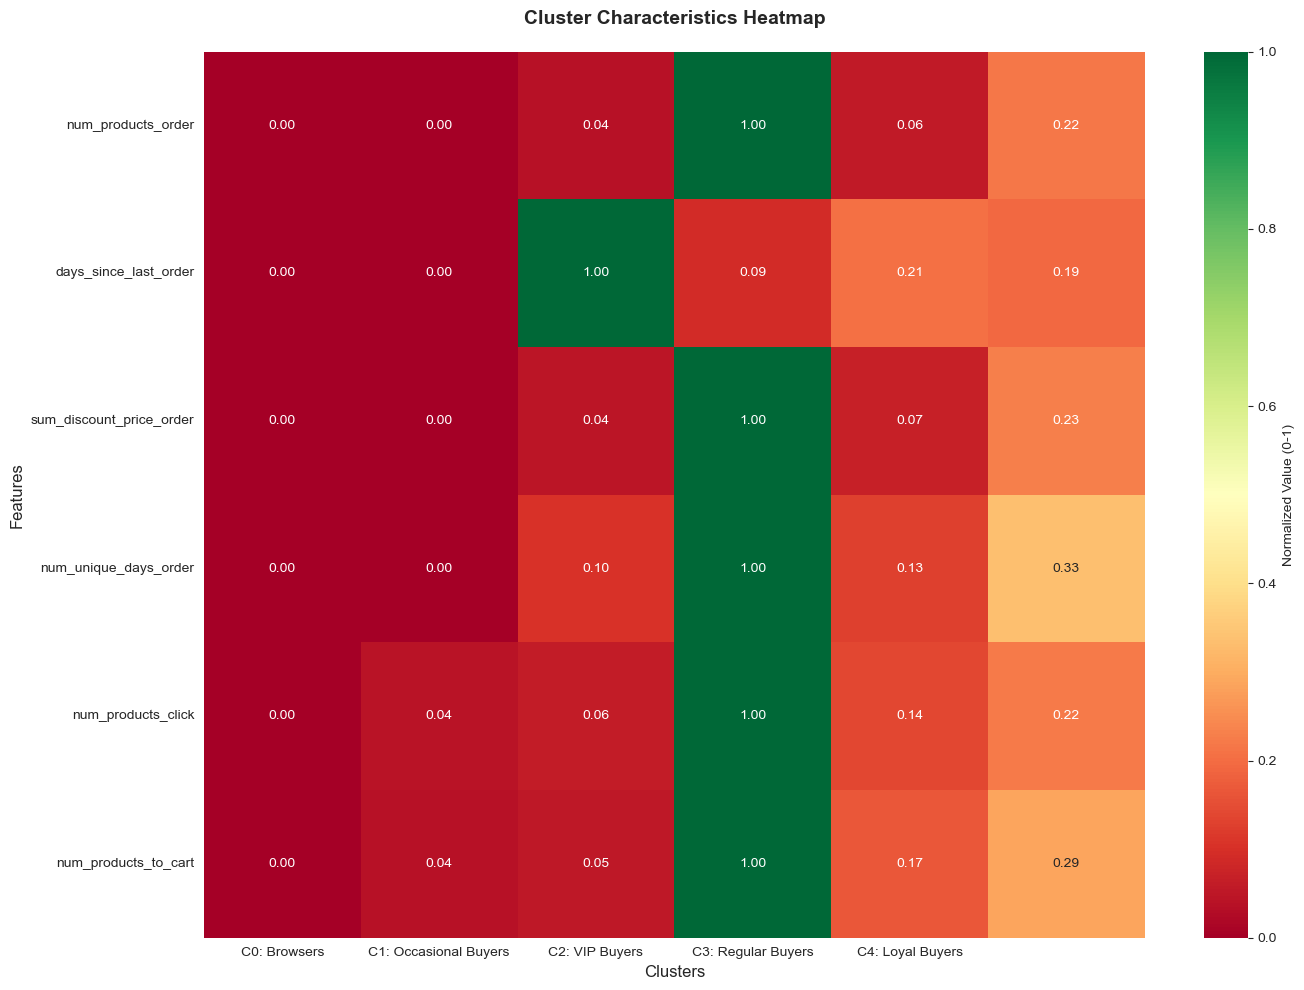

Heatmap saved to ../results/figures/cluster_heatmap.png


In [68]:
# Heatmap характеристик кластеров
plt.figure(figsize=(14, 10))

# Используем нормализованные средние значения
sns.heatmap(
    cluster_means_normalized.T,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn',
    cbar_kws={'label': 'Normalized Value (0-1)'},
    xticklabels=[f"C{i}: {cluster_names[i]}" for i in range(optimal_k)],
    yticklabels=radar_features
)

plt.title('Cluster Characteristics Heatmap', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Clusters', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'cluster_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"Heatmap saved to {FIGURES_DIR}/cluster_heatmap.png")

## 8. Save Clustering Results

In [69]:
# Сохранить кластеры и профили
# 1. Cluster assignments
cluster_assignments = df_train[['user_id', 'cluster', 'target']].copy()
cluster_assignments['cluster_name'] = cluster_assignments['cluster'].map(cluster_names)

cluster_assignments.to_csv(os.path.join(MODELS_DIR, 'user_clusters.csv'), index=False)
print(f"Cluster assignments saved to {MODELS_DIR}/user_clusters.csv")

# 2. Cluster profiles
cluster_profiles_df = cluster_means.copy()
cluster_profiles_df['cluster_name'] = cluster_profiles_df.index.map(cluster_names)
cluster_profiles_df['description'] = cluster_profiles_df.index.map(cluster_descriptions)
cluster_profiles_df['conversion_rate'] = conversion_by_cluster['Conversion Rate'].values
cluster_profiles_df['size'] = conversion_by_cluster['Total Users'].values

cluster_profiles_df.to_csv(os.path.join(MODELS_DIR, 'cluster_profiles.csv'))
print(f"Cluster profiles saved to {MODELS_DIR}/cluster_profiles.csv")

# 3. Summary report
print("\n" + "="*70)
print("CLUSTERING SUMMARY")
print("="*70)
print(f"\nNumber of clusters: {optimal_k}")
print(f"Total users: {len(df_train):,}")
print(f"\nCluster Overview:")
print(cluster_profiles_df[['cluster_name', 'size', 'conversion_rate', 'description']])

print("\n" + "="*70)
print("NEXT STEPS")
print("="*70)
print("1. Use cluster assignments for personalized marketing")
print("2. Create business recommendations (notebook 06)")
print("3. Build predictive models per cluster")
print("4. Design A/B test strategies per segment")
print("="*70)

Cluster assignments saved to ../models/user_clusters.csv
Cluster profiles saved to ../models/cluster_profiles.csv

CLUSTERING SUMMARY

Number of clusters: 5
Total users: 1,835,147

Cluster Overview:
              cluster_name    size  conversion_rate  \
cluster                                               
-1          Inactive Users  608834        19.079585   
 0                Browsers  728631        25.495072   
 1       Occasional Buyers   85756        40.518448   
 2              VIP Buyers   21806        95.991929   
 3          Regular Buyers  277784        68.165553   
 4            Loyal Buyers  112336        78.124555   

                                             description  
cluster                                                   
-1           Very low engagement, minimal or no activity  
 0                          Mostly browsing, rarely buys  
 1                   Moderate engagement, buys sometimes  
 2       Premium customers, almost guaranteed conversion  
 3    